In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

Blank Image


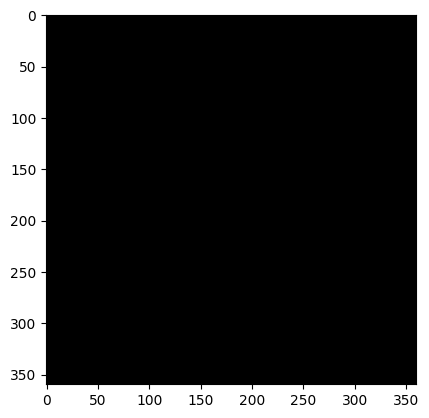

In [3]:
IMG_DIMS = (360,360)
CENTER = (IMG_DIMS[0]//2, IMG_DIMS[1]//2)
RADIUS = 160

WHITE = (255, 255, 255)

image = np.zeros(IMG_DIMS, dtype=np.uint8)

print("Blank Image")
plt.imshow(image, cmap='gray')

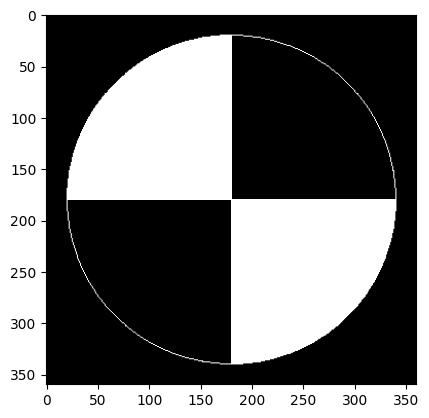

In [4]:
# Draw Quadrants.
image = cv2.ellipse(image, CENTER, axes=(RADIUS, RADIUS), angle=0, startAngle=0, endAngle=90, color=WHITE)
image = cv2.ellipse(image, CENTER, axes=(RADIUS, RADIUS), angle=0, startAngle=90, endAngle=180, color=WHITE)
image = cv2.ellipse(image, CENTER, axes=(RADIUS, RADIUS), angle=0, startAngle=180, endAngle=270, color=WHITE)
image = cv2.ellipse(image, CENTER, axes=(RADIUS, RADIUS), angle=0, startAngle=270, endAngle=360, color=WHITE)


# Draw lines to seperate quadrants.
image = cv2.line(image, (IMG_DIMS[0]//2 - 160, IMG_DIMS[1]//2), (IMG_DIMS[0]//2 + 160, IMG_DIMS[1]//2), color=WHITE)
image = cv2.line(image, (IMG_DIMS[0]//2, IMG_DIMS[1]//2 - RADIUS), (IMG_DIMS[0]//2, IMG_DIMS[1]//2 + RADIUS), color=WHITE)

# Fill in colors.
cv2.floodFill(image, None, (IMG_DIMS[0]//2 - 80, IMG_DIMS[1]//2 - RADIUS//2), 255)
cv2.floodFill(image, None, (IMG_DIMS[0]//2 + 80, IMG_DIMS[1]//2 + RADIUS//2), 255)
plt.imshow(image, cmap='gray')

### Method 1  : Laplacian

#### The laplacian derivative (first degree) = Vf = df'/dx + df'/dy. <br>
Here, df'/dx = f(x + 1, y) - f(x, y), and df'/dy = f(x, y + 1) - f(x, y).

#### The laplacian derivative (second degree) = V^2f = d^2f'/dx^2 + d^2f'/dy^2. <br>
Here, df'/dx = f(x + 1, y) + f(x - 1, y) - 2f(x, y), and d^2f'/dy = f(x, y + 1) + f(x, y - 1) - 2f(x, y).

Used for removing blurring + enhancing (highlighting) the edges


In [5]:
def laplacian_filter_4(images):
  
# As smoothing is achieved by smoothing in the neighbourhood, we can say that sharpening is done by
# spatial differentiation, where the strenght of the derivative operation is directly proportional to the magnitude of 
# intensity discontinuity at that point.
# Areas of edges (areas of high varying intensities) are emphasized while de emphasizes areas of slow varying intensities.

  laplacian_filter = []
  sharpened_images = []

  for image in images:
    # Image with padding for convineince (for use with a 3X3 filter).
    padded_image = image.copy()
    padded_image = cv2.copyMakeBorder(padded_image, 2, 2, 2, 2, cv2.BORDER_CONSTANT, None, 0)
    img_width, img_height = padded_image.shape[0:2]

    # Sharpening using first derivative (i.e Laplacian), non rotated no diagonal consideration.
    # partial_derivative_on_x = f(x + 1, y) - f(x, y)
    # partial_derivative_on_x_2 = f(x + 1, y) + f(x - 1, y) - 2f(x, y)

    # partial_derivative_on_y = f(x, y + 1) - f(x, y)
    # partial_derivative_on_y_2 = f(x, y + 1) + f(x, y - 1) - 2f(x, y)

    # combining, laplacian = f(x + 1, y) + f(x - 1, y) + f(x, y + 1) + f(x, y -1) - 4f(x, y)
    # For convinience, as the center coeff is -ve, negating the full filter so it can be added directly with base / original image.

    # in filter form, we have for n4 : 
    laplacian_filter_4 = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    laplacian_filtered_image_4 = cv2.filter2D(image, -1, laplacian_filter_4)
    laplacian_filter.append(laplacian_filtered_image_4)
    sharpened_image = cv2.addWeighted(image, 1, laplacian_filtered_image_4, 2, gamma=0)
    sharpened_images.append(sharpened_image)

  return laplacian_filter, sharpened_images

In [6]:
def laplacian_filter_8(images):
  laplacian_filter = []
  sharpened_images = []

  for image in images:
    # Image with padding for convineince (for use with a 3X3 filter).
    padded_image = image.copy()
    padded_image = cv2.copyMakeBorder(padded_image, 2, 2, 2, 2, cv2.BORDER_CONSTANT, None, 0)
    img_width, img_height = padded_image.shape[0:2]

    # Sharpening using second derivative (i.e Laplacian), with diagonal consideration.
    # For convinience, as the center coeff is -ve, negating the full filter so it can be added directly with base / original image.

    # in filter form, we have for n8 : 
    laplacian_filter_8 = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
    laplacian_filtered_image_8 = cv2.filter2D(image, -1, laplacian_filter_8)
    laplacian_filter.append(laplacian_filtered_image_8)

    sharpened_image_8 = cv2.addWeighted(image, 1, laplacian_filtered_image_8, 1.5, gamma=0)
    sharpened_images.append(sharpened_image_8)

  return laplacian_filter, sharpened_images

In [7]:

### Method 2. Unsharp masking method for sharpening (primarily used by publishing industry.)
### First, the image is to be blurred. Subtract said blurred image from the original. This becomes the 'mask'.
### Then, add the mask to hte original image.


In [8]:
def unsharp_masking(images, blurred_images):
  unsharp_mask = [] * len(images)
  sharpened_images = [] * len(images)

  for i in range(0, len(images)):
    mask = cv2.addWeighted(images[i], 1, blurred_images[i], -1, gamma=0)
    sharpened_image = cv2.addWeighted(images[i], 1, mask, 3, gamma=0) 
    unsharp_mask.append(mask)
    sharpened_images.append(sharpened_image)

  return unsharp_mask, sharpened_images


## Method 3 : Sorbel edge detector (Approximation of Roberts Cross Gradient)
### Here, image is processed in the X and Y axis one after another. The new image is the sum of X and Y results (i.e the edges highlighted) of the image.
### Calculation is based on gradient of images intensity. Here, gradient = Vf = [df'/dx    df'/dy].
### This vector points in the direction of the greatest rate of change of intensity at some location(x, y). The magnitude of this vector is the value of
### rate of change in direction of said gradiant vector. Rather than finding magnitude via sqrt(Vf.x^2 + Vf.y^2), we can do : 
### mag(x, y) = |Vf.x| + |Vf.y|

### The x derivate is : [1, 0, -1] and the 1D gaussian filter is [1, 2, 1]. Here, the values (1, 2) are important as we give more importance to the center compared to the rest.
### The gaussian filter * x derivative = [[1, 0, -1], [2, 0, -2], [1, 0, -1]] (gx or sorbel x)
### Similarly, for y derivative we have [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]

In [9]:
def sorbel(images):
    sorbel_filter = []
    sharpened_images = []

    sorbel_x = []
    sorbel_y = []

    for image in images:
      # Image with padding for convineince (for use with a 3X3 filter).
      padded_image = image.copy()
      padded_image = cv2.copyMakeBorder(padded_image, 2, 2, 2, 2, cv2.BORDER_CONSTANT, None, 0)
      img_width, img_height = padded_image.shape[0:2]
 
      gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
      sorbel_x_filtered = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5) # x-axis
      sorbel_x.append(np.abs(sorbel_x_filtered))

      gy = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
      sorbel_y_filtered = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=5) # x-axis
      sorbel_y.append(np.abs(sorbel_y_filtered))


      sorbel_x_filtered = np.abs(cv2.filter2D(image, -1, gx))
      sorbel_y_filtered = np.abs(cv2.filter2D(image, -1, gy))
      
      sorbel_filtered = cv2.addWeighted(sorbel_x_filtered, 1, sorbel_y_filtered, 1, gamma=0)
      sorbel_filter.append(sorbel_filtered)
      sharpened_image = cv2.addWeighted(image, 1, sorbel_filtered, 2, gamma=0)
      sharpened_images.append(sharpened_image)

    return sorbel_filter, sharpened_images, (sorbel_x), (sorbel_y)

Frequency domain filtering (Low pass)

Ideal High Pass Filter

A frequency domain filter given by 1 - Ideal Low Pass Filter 

That is, H(u, v) = {0 if D(u, v) >= D0, 1 if D(u, v) < D0} \
Here, D0 is the cutoff frequency, or the frequencies we wish to attenutate.

In [10]:
def ideal_high_pass_filter(image, d0):
  m, n = image.shape

  H = np.zeros((m, n), dtype=np.float32)
  for u in range(m):
    for v in range(n):
      d = np.sqrt((u - m / 2)**2 + (v - n / 2) ** 2)
      if d <= d0:
        # Inside not  allowed - frequency range
        H[u, v] = 0
      else:
        H[u, v] = 1
  
  return H

Visualizing the  Ideal High Pass Filter

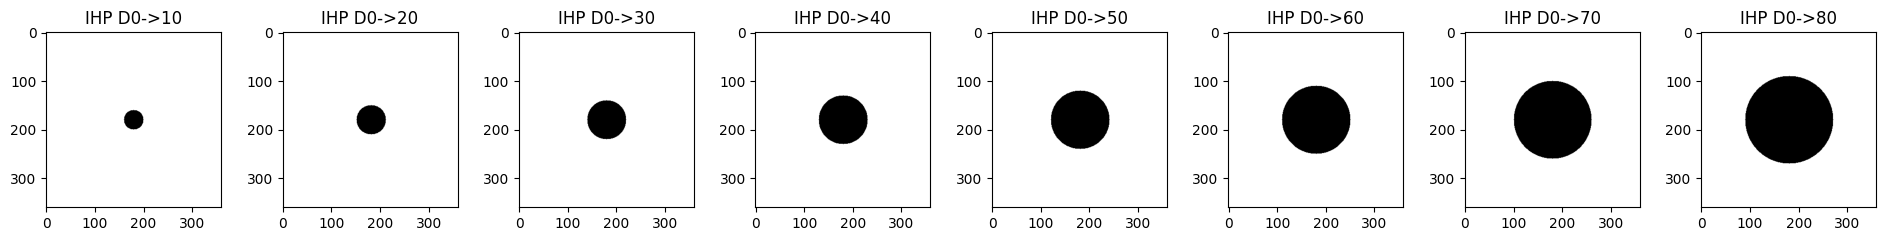

In [11]:
ihp_filters = []
for i in range(1, 10):
  ihp_filters.append(ideal_high_pass_filter(image, i * 10))
  
plt.figure(figsize=(30,5))

for i in range(1, 9):
  plt.subplot(2,10, i)
  plt.imshow(ihp_filters[i],cmap='gray')
  plt.title(('IHP D0->' + str(i * 10)))
  plt.axis('on')


plt.show()

In [12]:
# Assume iamge is in spatial domain
def apply_freq_filter(filter, image):
  ft = np.fft.fft2(image)
  ft_shifted = np.fft.fftshift(ft)

  g = ft_shifted * filter

  g_spatial = np.fft.ifftshift(g)
  g_spatial = np.fft.ifft2(g_spatial)

  return g, g_spatial

<Figure size 3000x500 with 0 Axes>

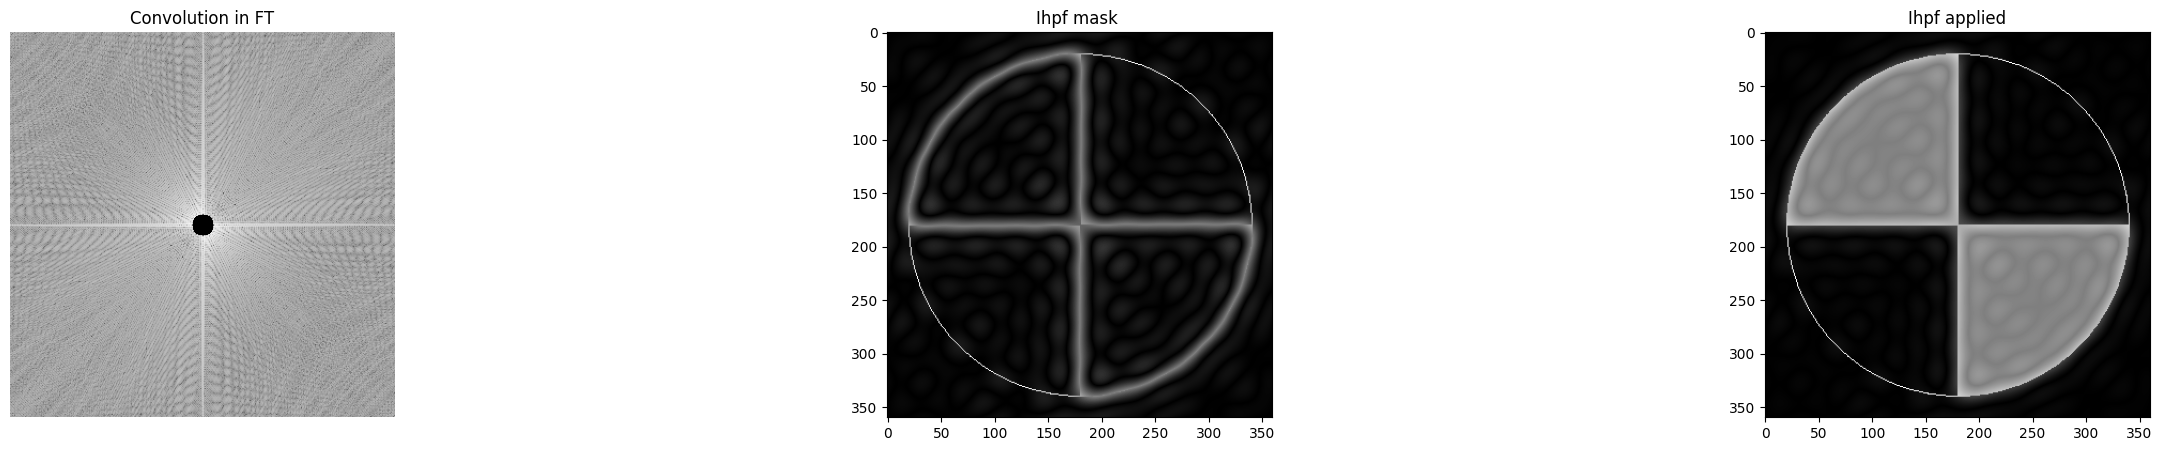

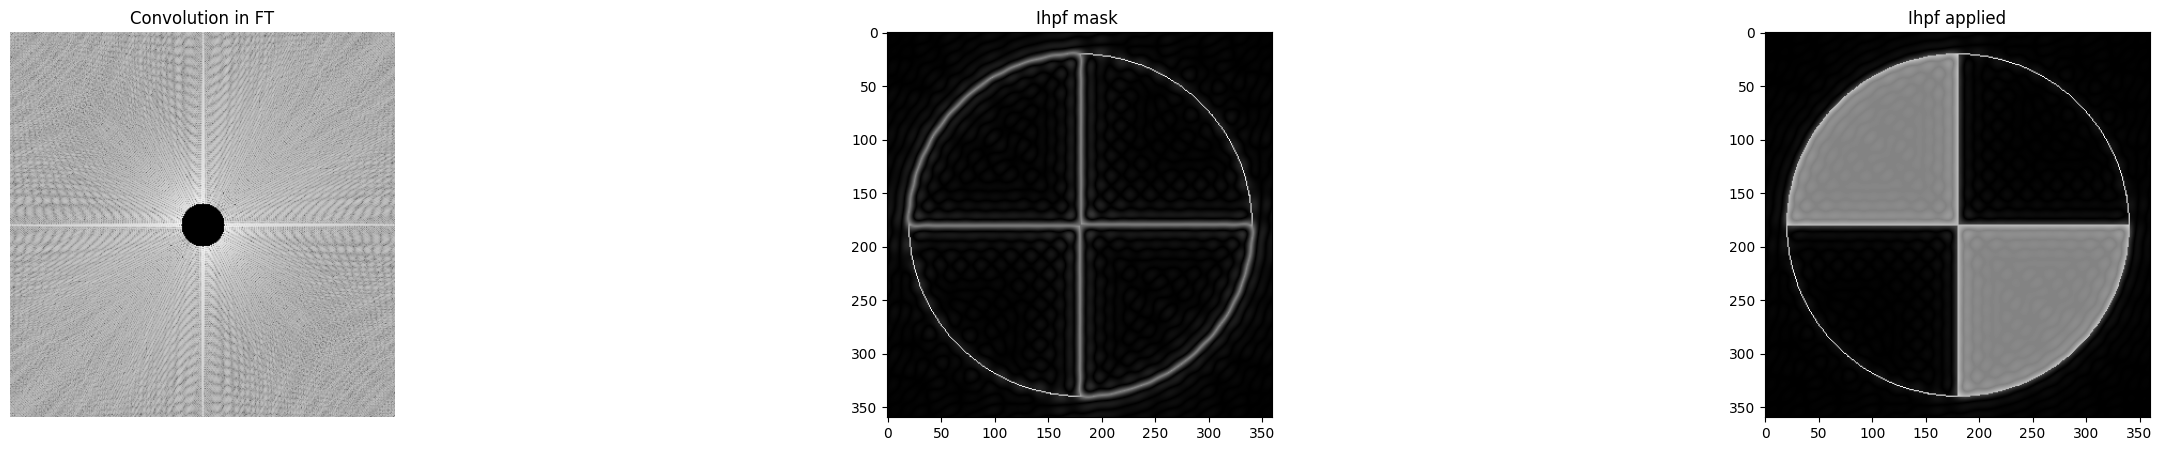

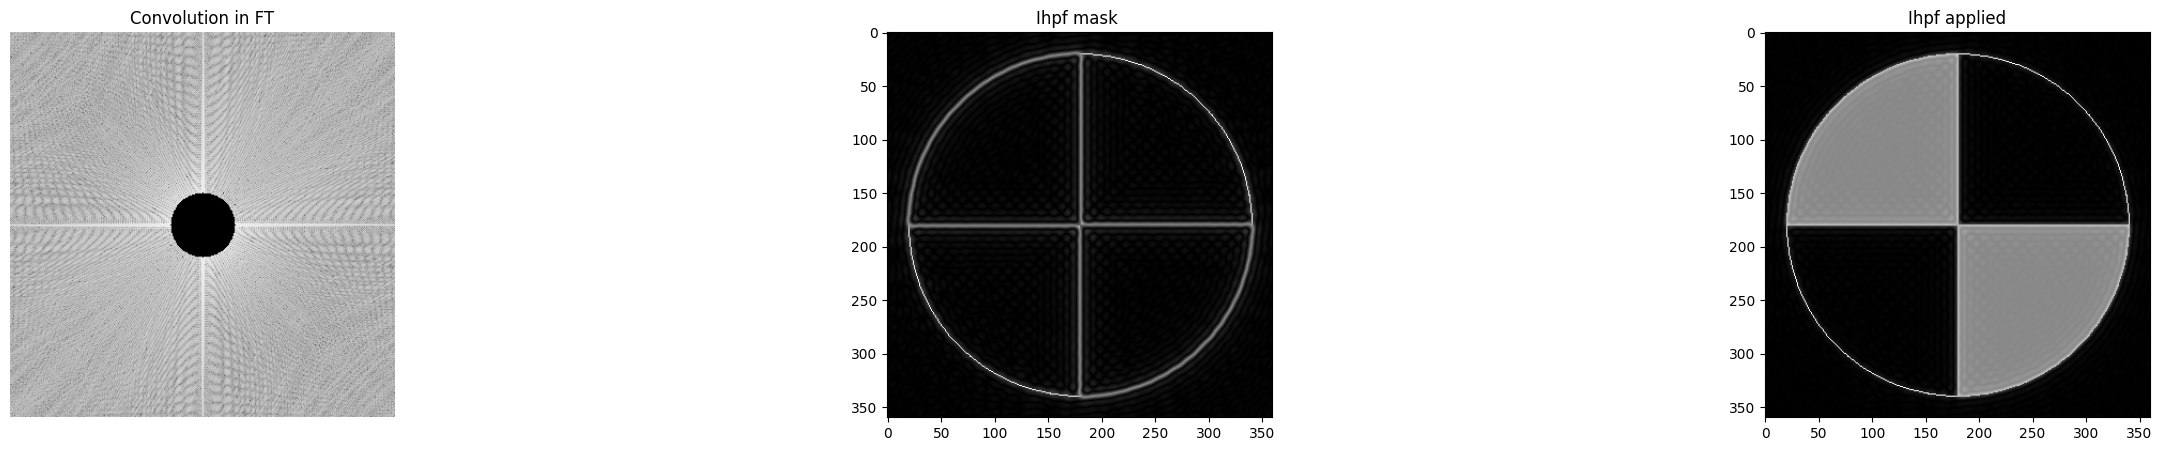

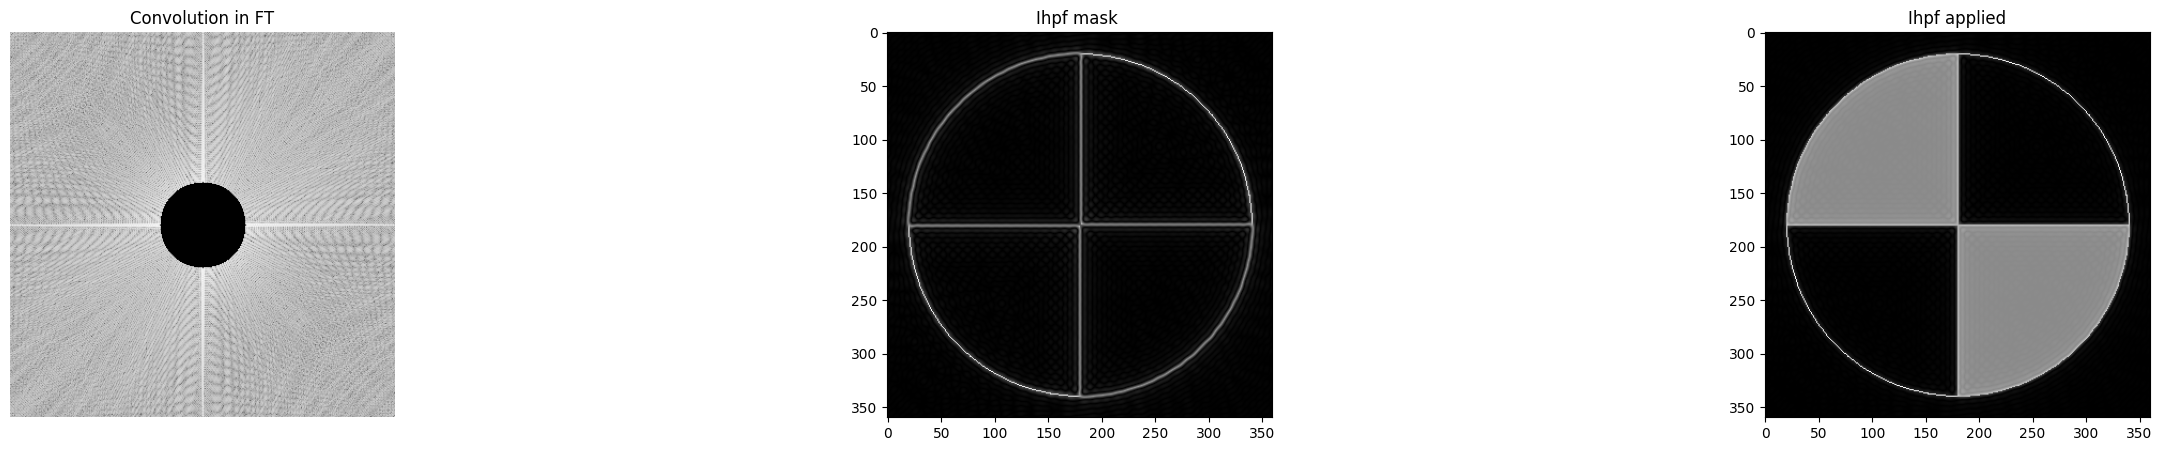

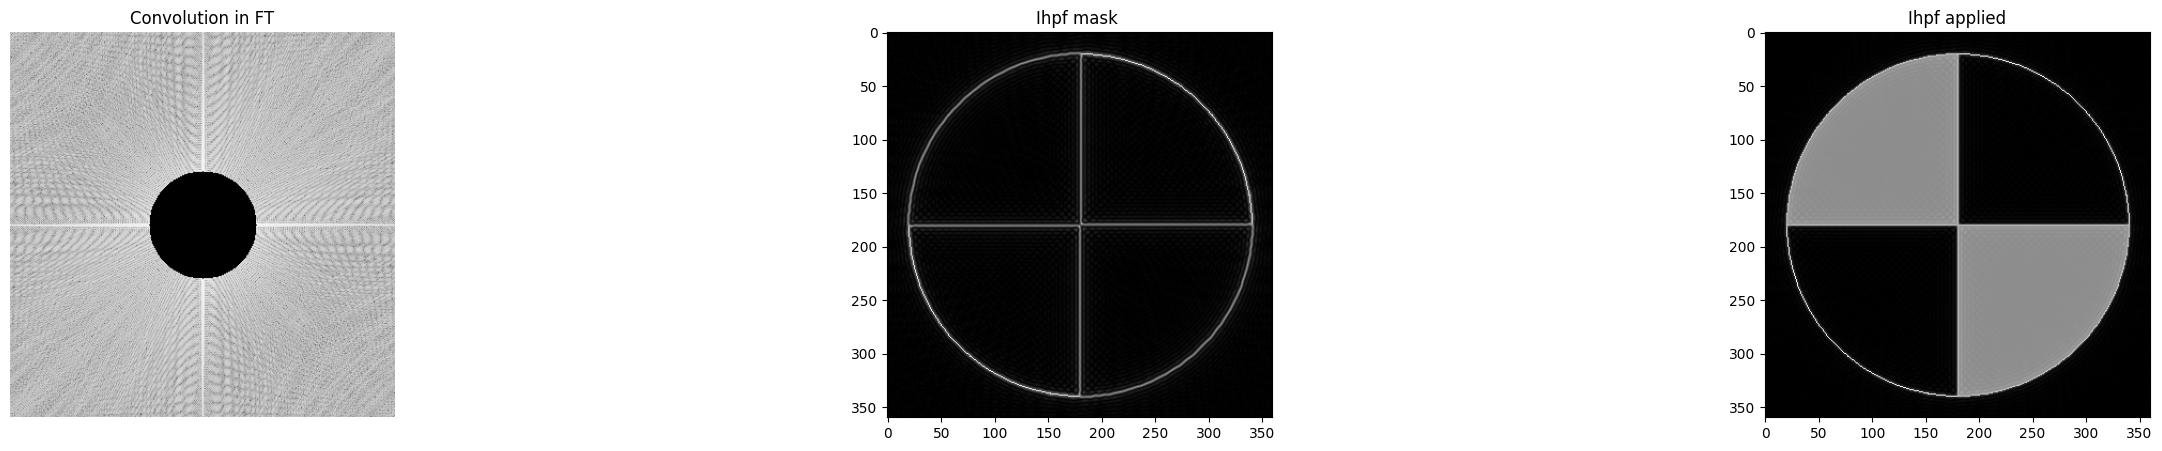

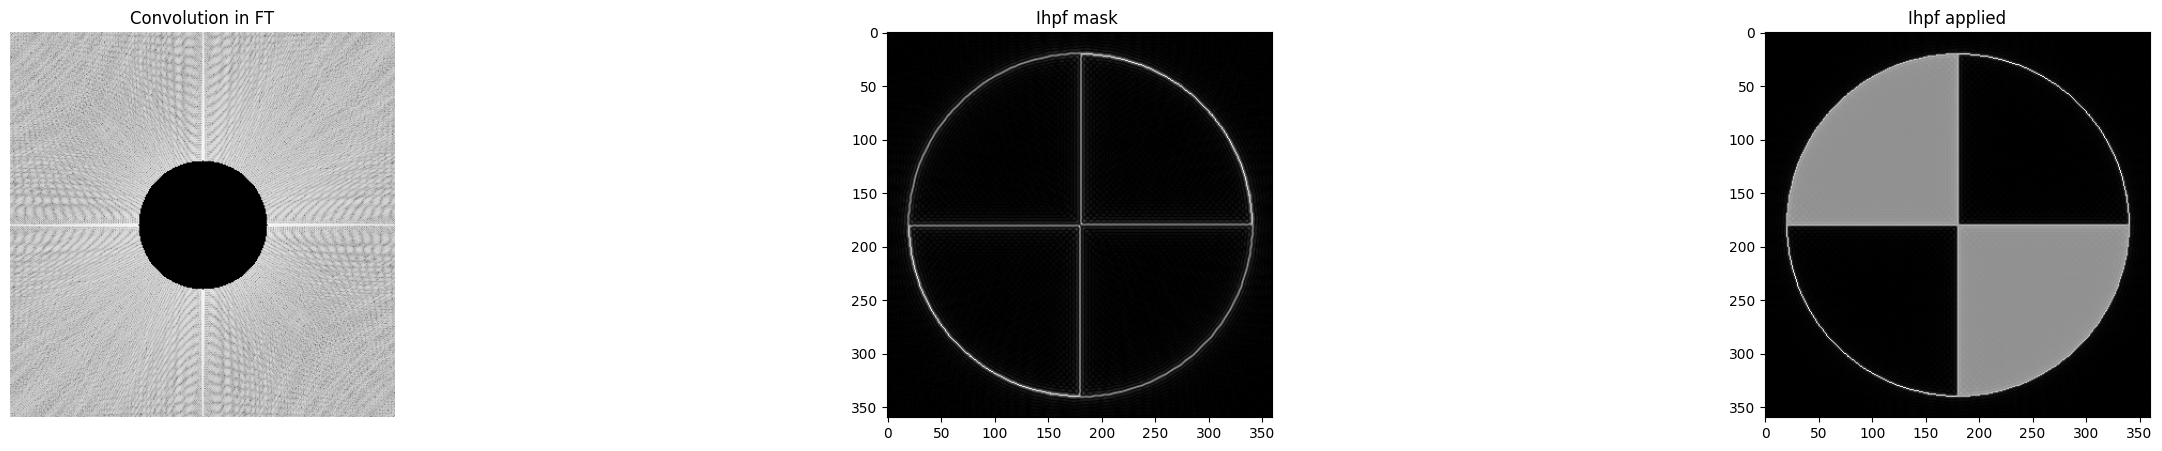

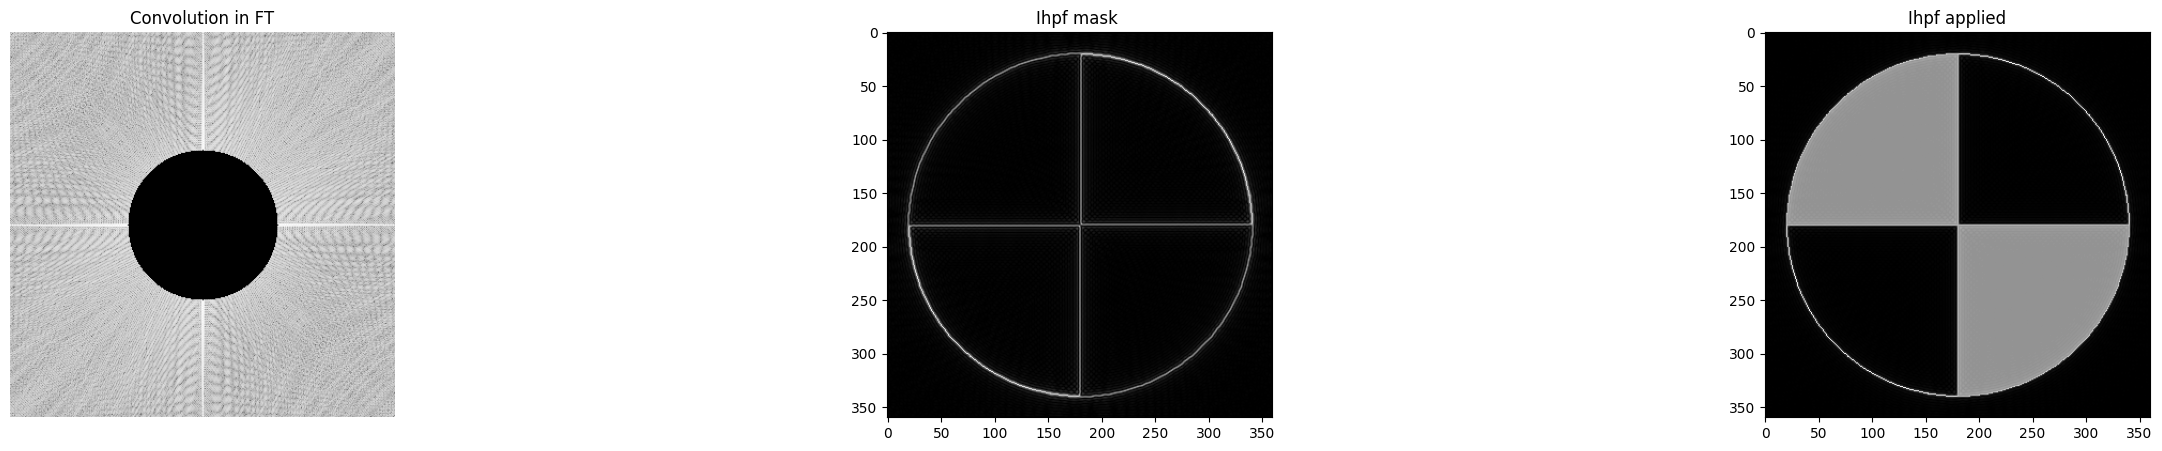

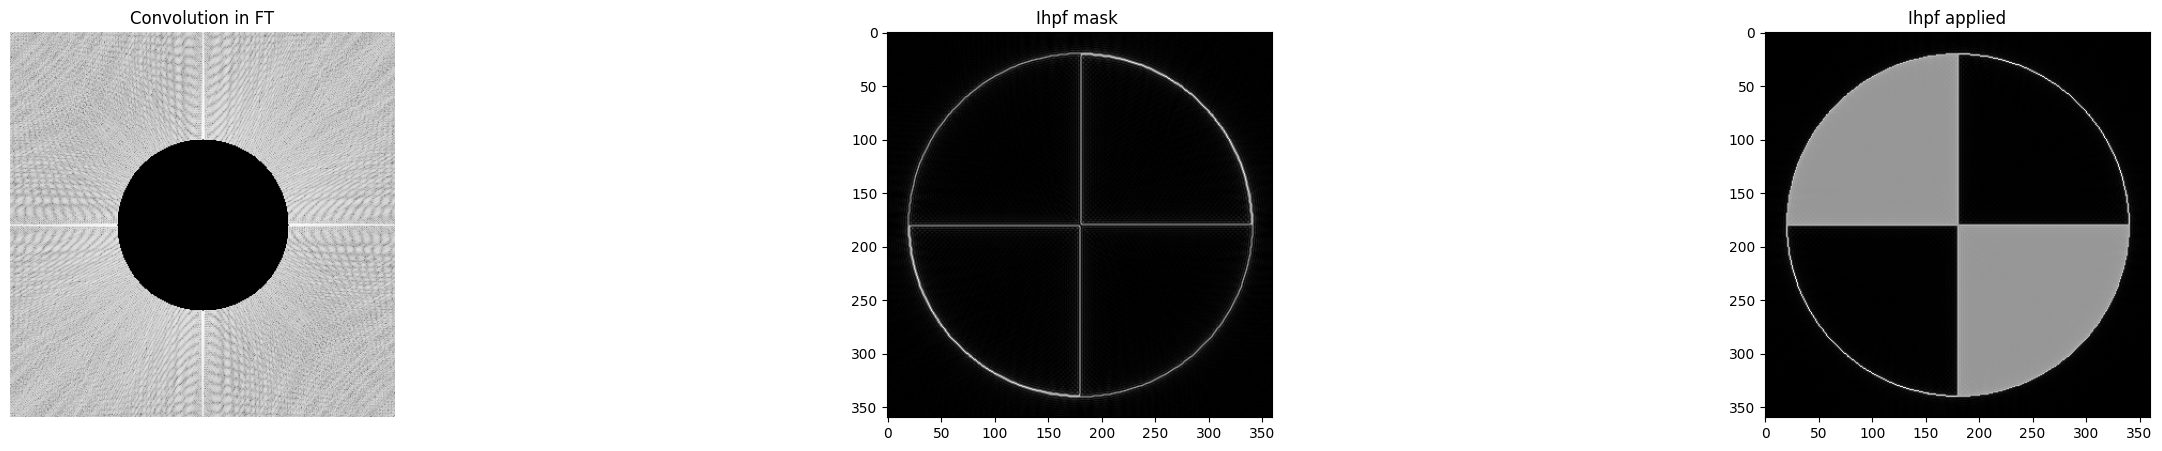

In [13]:
ihpf, ihp_applied = [], []
for i in range(0,9):
  g, g_spatial = apply_freq_filter(ihp_filters[i], image)
  ihpf.append(g)
  ihp_applied.append(g_spatial)

plt.figure(figsize=(30,5))

for i in range(0, 8):
  plt.figure(figsize=(100,5))

  plt.subplot(1,9, 1)
  plt.imshow(np.log1p(np.abs(ihpf[i])),cmap='gray')
  plt.title('Convolution in FT')
  plt.axis('off')

  plt.subplot(1,9,2)

  plt.imshow((np.abs(ihp_applied[i])),cmap='gray')
  plt.title('Ihpf mask ')
  plt.axis('on')

  
  plt.subplot(1,9,3)

  plt.imshow((np.abs(ihp_applied[i])) + image,cmap='gray')
  plt.title('Ihpf applied')
  plt.axis('on')

plt.show()

# The Butterworth high Pass Filter

A frequency domain given by :
H(u, v) = 1 / (1 + (D0 / D) ^ 2n) \
Where, \
D = sqrt((u - m / 2) ** 2 + (v - n / 2) ** 2) \
D0 = cut off frequency \
n = order of filter 

In [14]:
def butter_worth_high_pass(image, d0, order):
  m, n = image.shape
  H = np.zeros((m, n), dtype=np.float64)
  for u in range(m):
    for v in range(n):
      d = np.sqrt((u - m / 2) ** 2 + (v - n / 2) ** 2)
      H[u, v] = 1 / (1 + (d0/d) ** (2 * order))

  return H

C:\Users\Tarun\AppData\Local\Temp\ipykernel_13152\2239893868.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  H[u, v] = 1 / (1 + (d0/d) ** (2 * order))


<Figure size 20000x500 with 0 Axes>

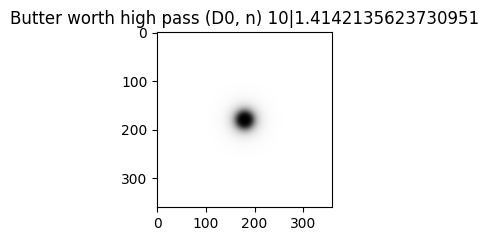

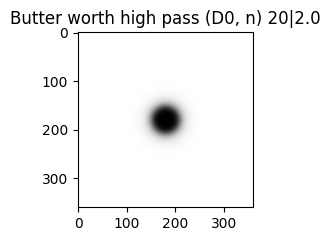

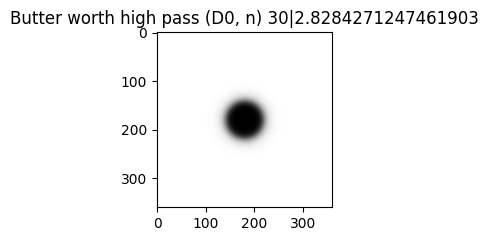

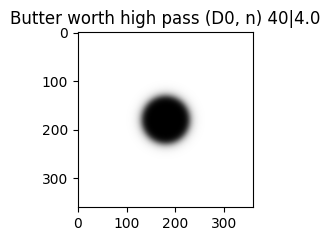

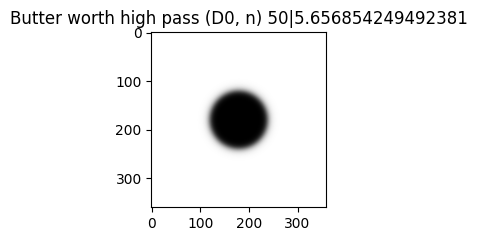

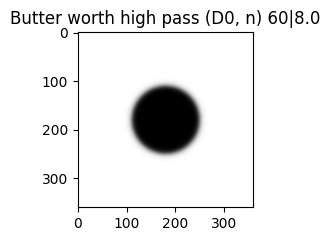

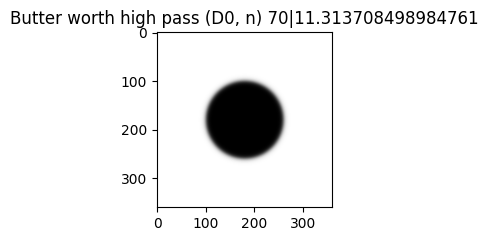

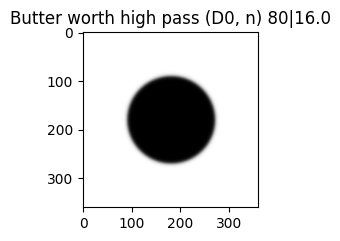

<Figure size 20000x500 with 0 Axes>

In [15]:
butter_worth_high_pass_filters = []
for i in range(1, 10):
  butter_worth_high_pass_filters.append(butter_worth_high_pass(image, i * 10, 2 ** (i / 2)))


plt.figure(figsize=(200,5))

plt.figure(figsize=(200,5))

for i in range(1, 9):
  plt.subplot(2,10, i)
  plt.imshow(butter_worth_high_pass_filters[i],cmap='gray')
  plt.title(('Butter worth high pass (D0, n) ' + str(i * 10) + '|' + str(2 ** (i/2))))
  plt.axis('on')
  plt.figure(figsize=(200,5))

plt.show()

<Figure size 3000x500 with 0 Axes>

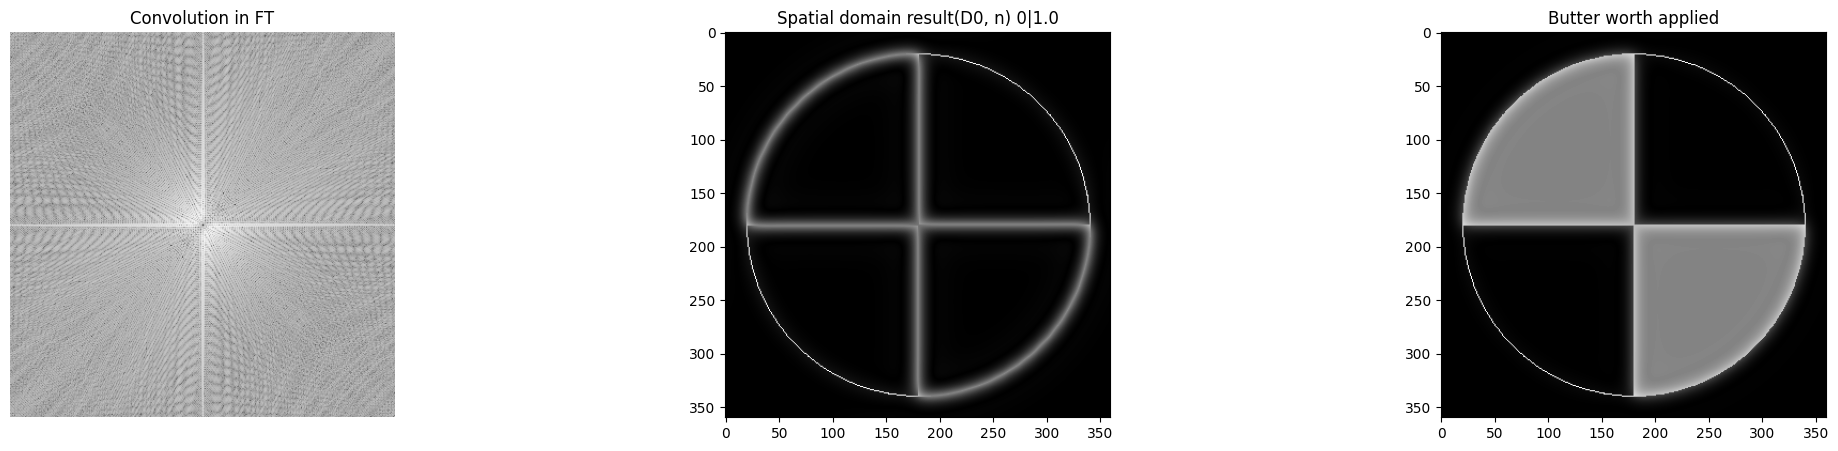

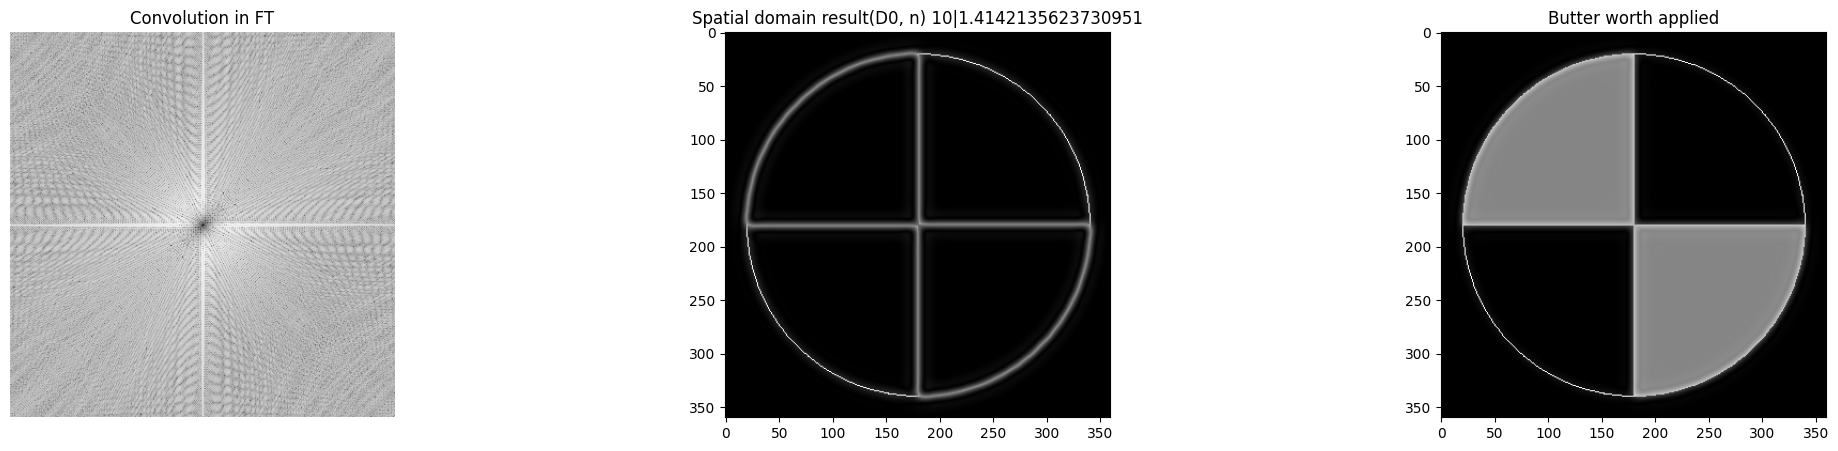

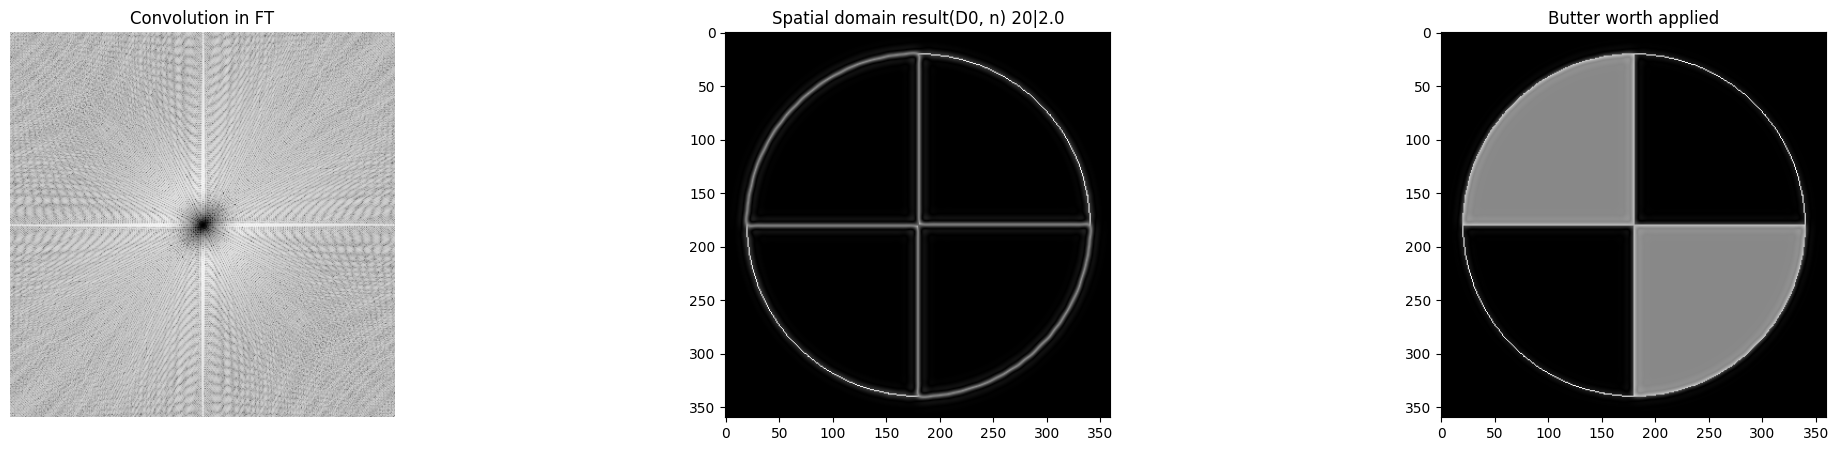

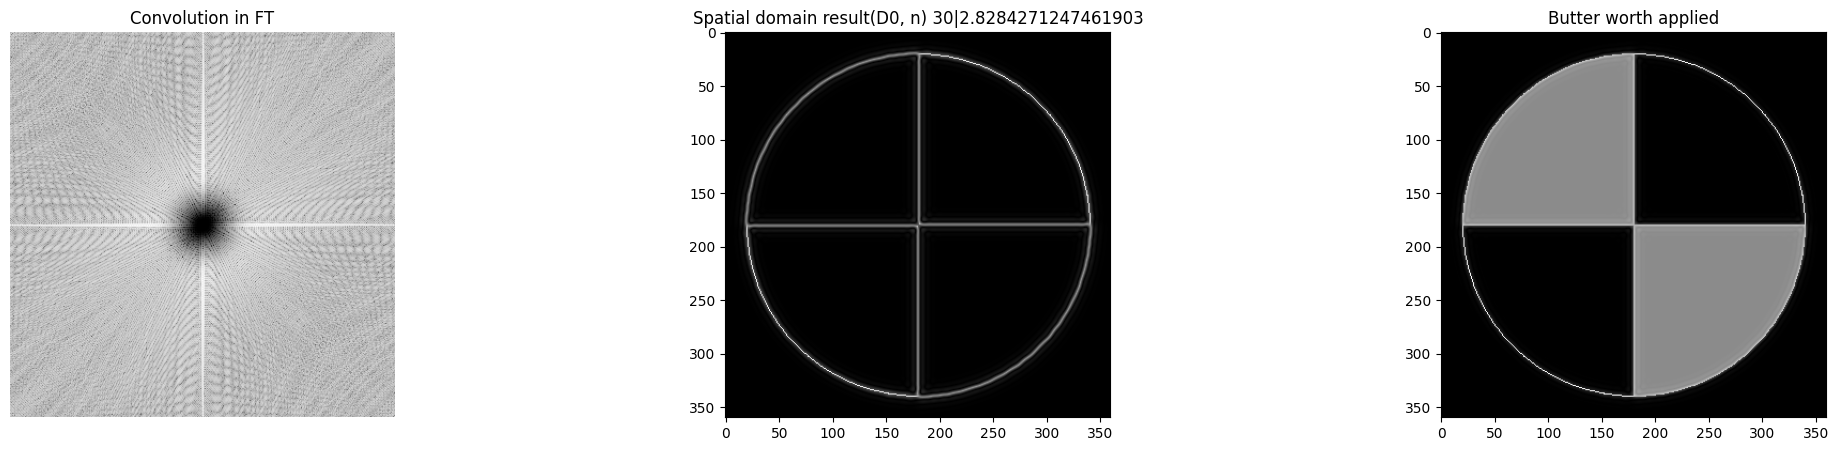

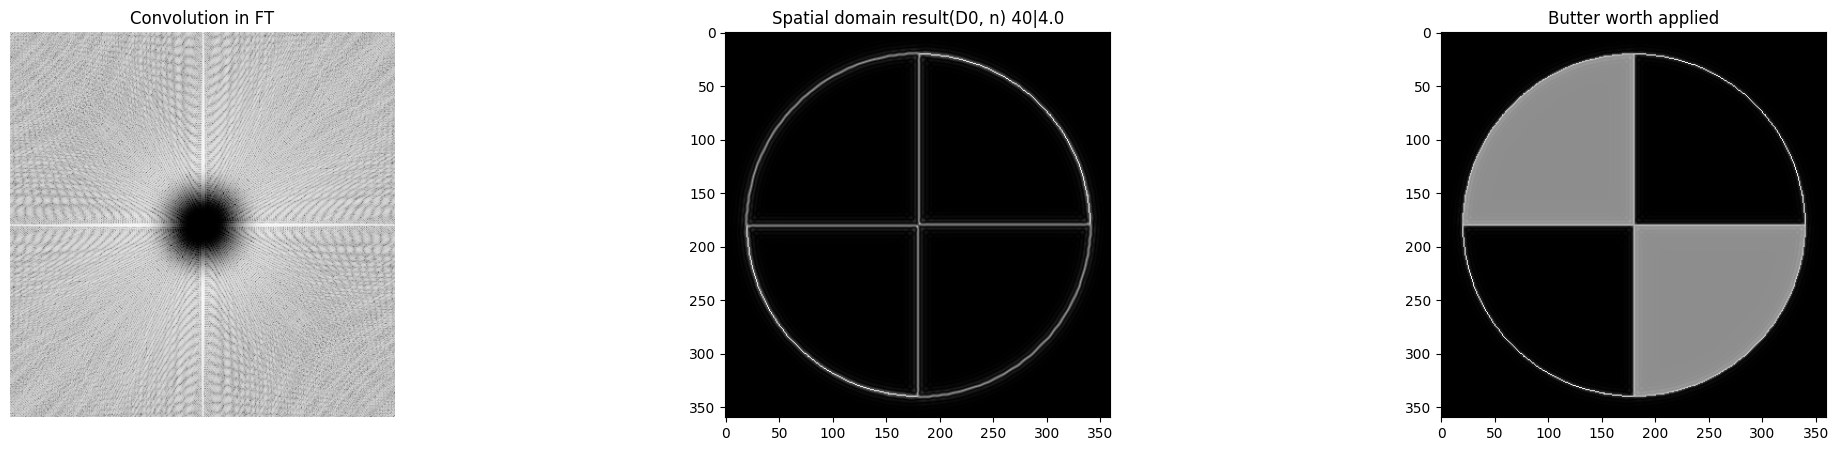

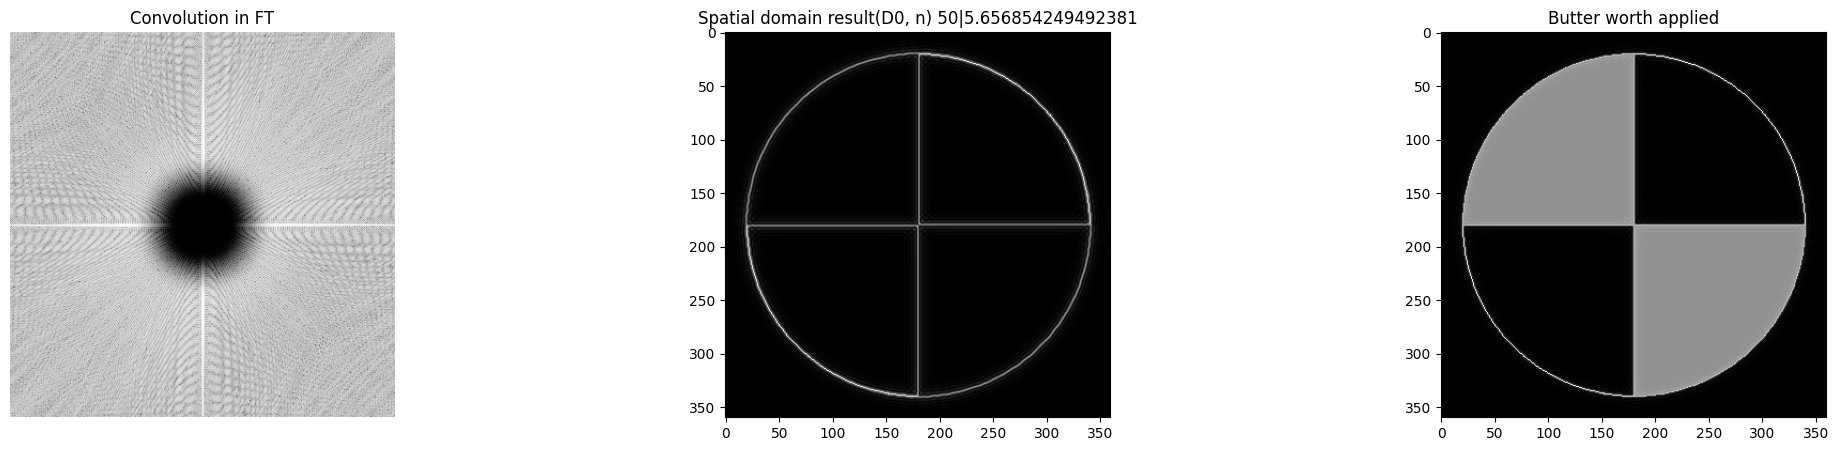

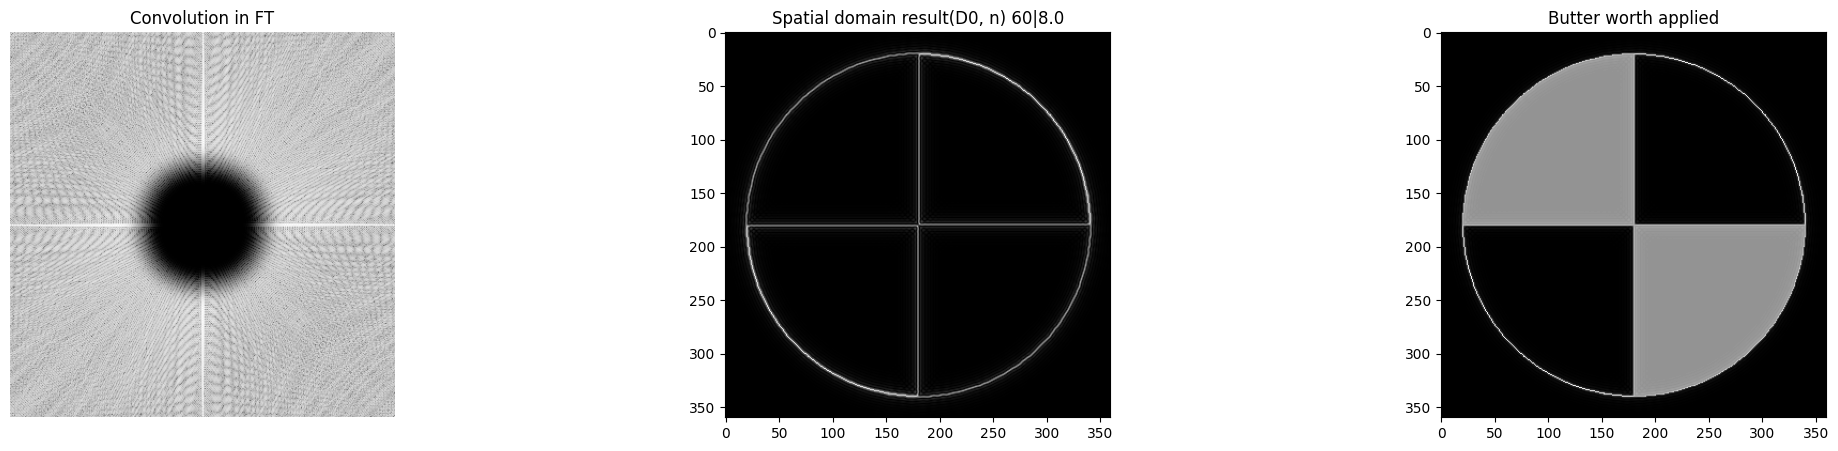

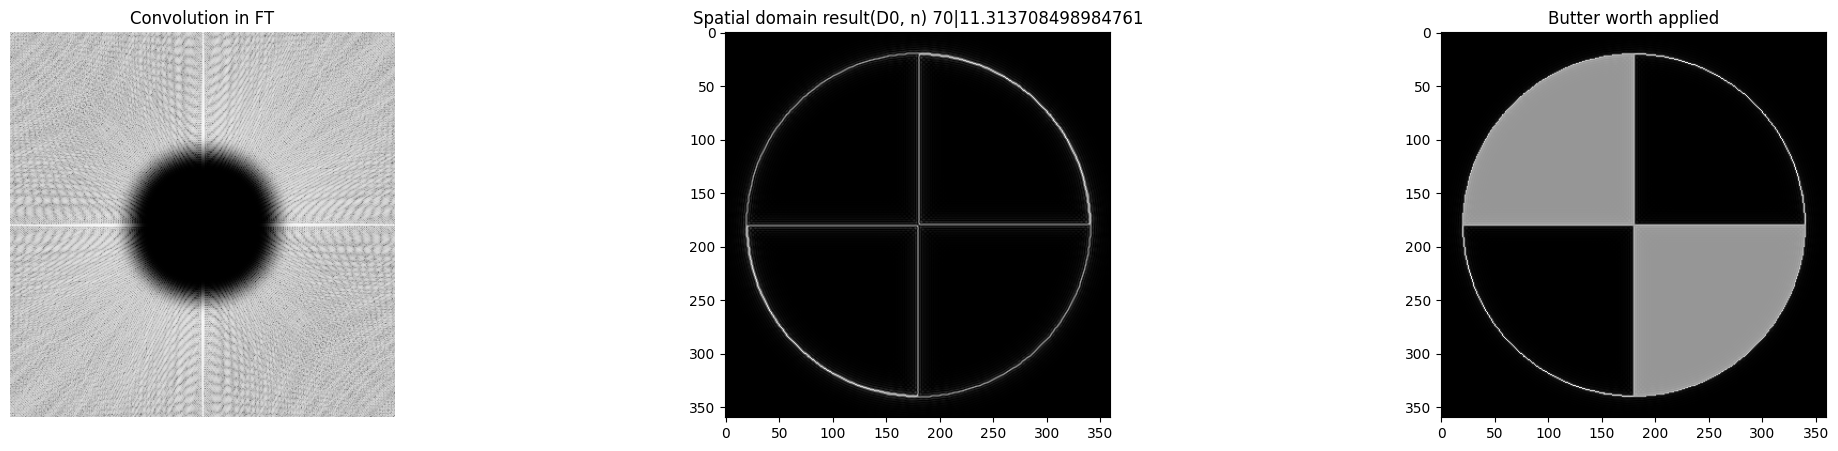

In [16]:
bhpf, bhp_applied = [], []
for i in range(0,9):
  g, g_spatial = apply_freq_filter(butter_worth_high_pass_filters[i], image)
  bhpf.append(g)
  bhp_applied.append(g_spatial)

plt.figure(figsize=(30,5))

for i in range(0, 8):
  plt.figure(figsize=(100,5))

  plt.subplot(1,11, 1)
  plt.imshow(np.log1p(np.abs(bhpf[i])),cmap='gray')
  plt.title('Convolution in FT')
  plt.axis('off')

  plt.subplot(1,11,2)

  plt.imshow((np.abs(bhp_applied[i])),cmap='gray')
  plt.title('Spatial domain result' + str('(D0, n) ') + str(i * 10) + '|' + str(2 ** (i/2)))
  plt.axis('on')

  plt.subplot(1,11,3)

  plt.imshow((np.abs(bhp_applied[i])) + image,cmap='gray')
  plt.title('Butter worth applied')
  plt.axis('on')


plt.show()

In [17]:
# Blur image (for unsharp masking)
average_blur_filter_3 = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])
average_blurred_image_3 = cv2.filter2D(image, -1, average_blur_filter_3)
average_blurred_image_5 = cv2.blur(image, (5, 5))

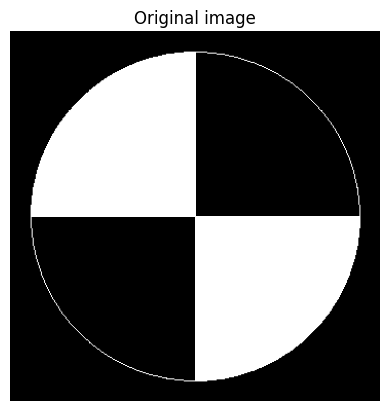

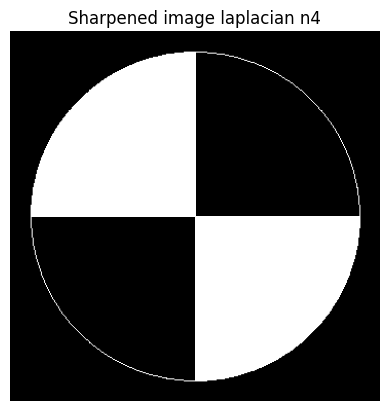

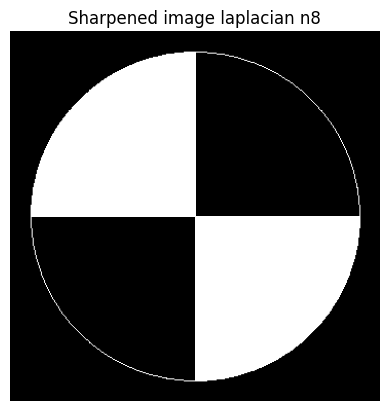

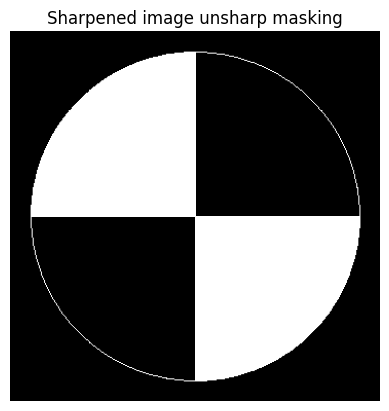

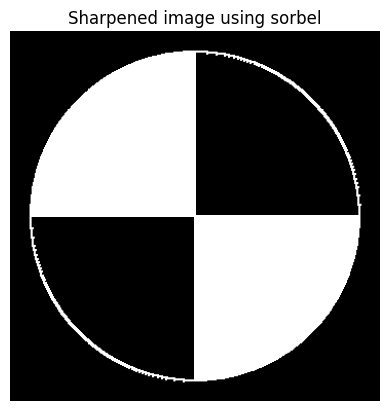

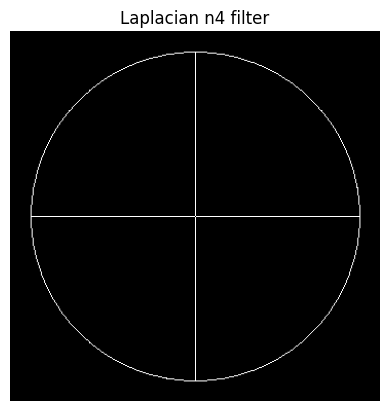

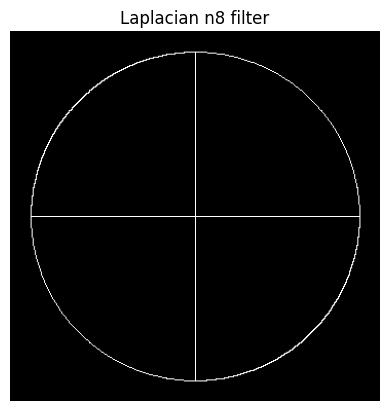

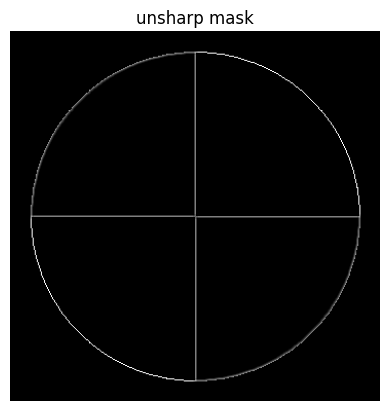

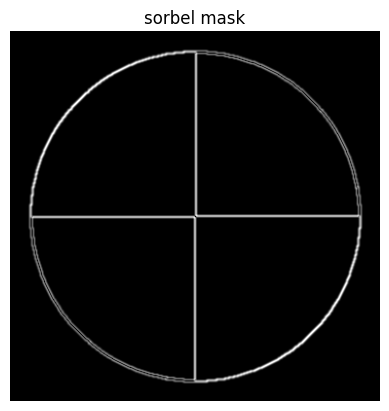

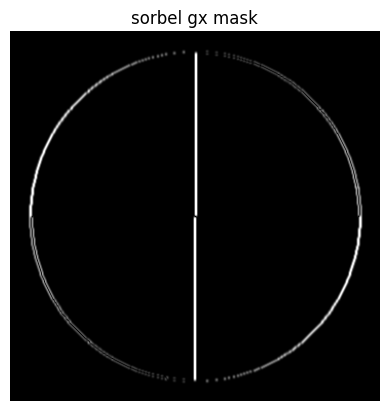

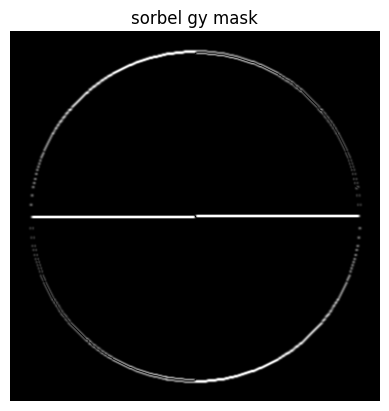

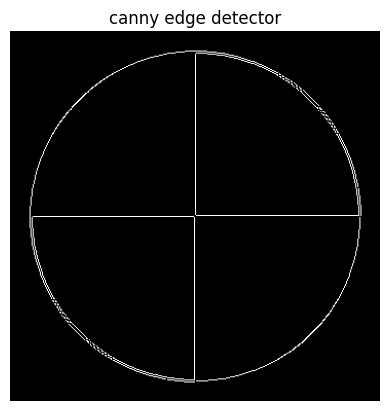

In [19]:
# Driver code for sharpening
imgs = [image]

# laplacian filter and the sharpened image (n4)
laplacian_filter_n4, sharpened_images_laplacian_4 = laplacian_filter_4(imgs)

# laplacian filter and the sharpened image (n8)
laplacian_filter_n8, sharpened_images_laplacian_8 = laplacian_filter_8(imgs)

# Unsharp mask and sharpened images
unsharp_mask, sharpened_images_unsharp = unsharp_masking(imgs, [average_blurred_image_5])

# sorbel mask and sharpened_images
sorbel_filter, sharpened_images_sorbel, sorbel_gx, sorbel_gy = sorbel(imgs)

for i in range(len(imgs)):
  plt.imshow(imgs[i],cmap='gray')
  plt.title('Original image')
  plt.axis('off')
  plt.show()
  
  plt.imshow(sharpened_images_laplacian_4[i],cmap='gray')
  plt.title('Sharpened image laplacian n4')
  plt.axis('off')
  plt.show()

  plt.imshow(sharpened_images_laplacian_8[i],cmap='gray')
  plt.title('Sharpened image laplacian n8')
  plt.axis('off')
  plt.show()

  plt.imshow(sharpened_images_unsharp[i],cmap='gray')
  plt.title('Sharpened image unsharp masking')
  plt.axis('off')
  plt.show()

  plt.imshow(sharpened_images_sorbel[i],cmap='gray')
  plt.title('Sharpened image using sorbel')
  plt.axis('off')
  plt.show()

  plt.imshow(laplacian_filter_n4[i],cmap='gray')
  plt.title('Laplacian n4 filter')
  plt.axis('off')
  plt.show()

  plt.imshow(laplacian_filter_n8[i],cmap='gray')
  plt.title('Laplacian n8 filter')
  plt.axis('off')
  plt.show()

  plt.imshow(unsharp_mask[i],cmap='gray' )
  plt.title('unsharp mask')
  plt.axis('off')
  plt.show()

  plt.imshow(sorbel_gx[i] + sorbel_gy[i], cmap='gray')
  plt.title('sorbel mask')
  plt.axis('off')
  plt.show()

  plt.imshow(sorbel_gx[i], cmap='gray')
  plt.title('sorbel gx mask')
  plt.axis('off')
  plt.show()

  plt.imshow(sorbel_gy[i], cmap='gray')
  plt.title('sorbel gy mask')
  plt.axis('off')
  plt.show()

  plt.imshow(cv2.Canny(image, 100, 200), cmap='gray')
  plt.title('canny edge detector')
  plt.axis('off')
  plt.show()